In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('C:/Users/vince/Documents/GitHub/BeatTheBookie/sql/closing_odds.csv.gz', compression='gzip', sep=',', quotechar='"')
print('Reading completed. Total rows {}'.format(len(data)))
#data.info()

Reading completed. Total rows 479440


In [6]:
#round((1/ data[['max_odds_home_win',]]).sum(axis=1).sort_values(),1).value_counts().sort_index()

# CONSENCUS PROBABILITY

# 1. MINIMUM CHANCE
data['min_ch_home'] = 1 / data.max_odds_home_win
data['min_ch_draw'] = 1 / data.max_odds_draw
data['min_ch_away'] = 1 / data.max_odds_away_win

#sum
data['sum_min_chances'] = data.min_ch_home + data.min_ch_draw + data.min_ch_away


# 2. DETECT FORKS

def fork(row):
    if min(row['n_odds_home_win'],row['n_odds_draw'],row['n_odds_away_win']) < 5:
        return 0
    elif row['sum_min_chances'] > 0.95: #era 1 
        return 0
    else:
        return 1

data['fork'] = data.apply(fork,axis = 1)
print('Forks detection complete')

num_successful_forks = sum(data['fork'])
print(f'Number of successful forks: {num_successful_forks}')

successful_forks = data[data['fork'] == 1]
random_forks = successful_forks.sample(n=5, random_state=42)

print('Random successful forks:')
print(random_forks)

with open('random_forks.txt', 'w') as file:
    file.write('Random successful forks:\n\n')
    random_forks.to_csv(file, sep='\t', index=False)


# 3. CONCENSUS PROBABILITY
#actually, we don't need this probability that much. but it will help us to make better split between wins bets
#data['p_cons_home'] = 1 / data.avg_odds_home_win
#data['p_cons_draw'] = 1 / data.avg_odds_draw
#data['p_cons_away'] = 1 / data.avg_odds_away_win
#data['p_cons_sum'] = data.p_cons_home + data.p_cons_draw + data.p_cons_away

Forks detection complete
Number of successful forks: 6136
Random successful forks:
        match_id                       league  match_date       home_team  \
327967    675954               Italy: Serie A  2013-04-27        Atalanta   
226328    549239  Argentina: Primera Division  2011-10-03  Colon Santa FE   
453744    842122      Armenia: Premier League  2015-03-01  Ararat Yerevan   
398749    768969       Spain: Superliga Women  2014-04-27        Huelva W   
155928    440722      Portugal: Primeira Liga  2010-04-05           Naval   

        home_score         away_team  away_score  avg_odds_home_win  \
327967           1           Bologna           1             2.7222   
226328           1  Estudiantes L.P.           1             2.6418   
453744           2     Shirak Gyumri           4             3.6425   
398749           2       Barcelona W           1             7.6240   
155928           2           Benfica           4             8.5807   

        avg_odds_draw  avg_

In [45]:
# YOUR BET

data['bet_home'] = 100 * data['min_ch_home'] / data['sum_min_chances']
data['bet_draw'] = 100 * data['min_ch_draw'] / data['sum_min_chances']
data['bet_away'] = 100 * data['min_ch_away'] / data['sum_min_chances']
data['sum_bet'] = data.bet_home + data.bet_draw + data.bet_away

#WINNER DETECTION

def winner(row):
    if row['home_score'] > row['away_score']: return 1
    elif row['home_score'] == row['away_score']: return 2
    elif row['home_score'] < row['away_score']: return 3
    else: return -1
    
data['REAL_WINNER'] = data.apply(winner, axis = 1) # 1 -home, 2 - draw, 3 - away

In [46]:
#forks_df = data[data.fork == 1].copy()

#forks_df = forks_df[forks_df.league.str.contains('Ukraine')]

def profit(row):
    if row['fork'] == 0: return 0
    if   row['REAL_WINNER'] == 1: return row['bet_home'] * (row['max_odds_home_win']) - 100
    elif row['REAL_WINNER'] == 2: return row['bet_draw'] * (row['max_odds_draw']) - 100
    elif row['REAL_WINNER'] == 3: return row['bet_away'] * (row['max_odds_away_win']) - 100
    else: return '-1'
    
# costs are always 100$    
data['PROFIT'] = data.apply(profit,axis = 1)

#print('Total Profit: {:.0f}\nTotal Costs: {}'.format(data.PROFIT.sum(), len(data)*100))
print('Total Profit: {}'.format(data.PROFIT.sum()))

Total Profit: 198859.90403323903


[]

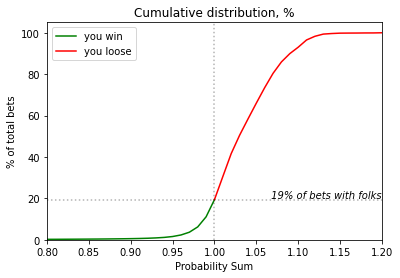

In [47]:
%matplotlib inline
#matplotlib.use('TkAgg')

# amount of evernts with forks and without forks
# based on probability sum
fig3, ax3 = plt.subplots()


plot_ser = data.sum_min_chances.round(2).value_counts().sort_index().cumsum()
plot_ser = plot_ser / plot_ser.max() * 100
#fig1 = plt.figure()
plot_ser[plot_ser.index <= 1].plot(color = 'green', label = 'you win') # we win
plot_ser[plot_ser.index >= 1].plot(color = 'red', label = 'you loose') # we lose
plt.xlim(.8,1.2)
plt.ylim(0,)
plt.xlabel('Probability Sum')
plt.ylabel('% of total bets')

plt.axvline(x=1, color = 'black', ls = ':', alpha = 0.3)

win_line = plot_ser[plot_ser.index <= 1].max().round(2)
plt.axhline(y=win_line, color = 'black', ls = ':', alpha = 0.3)

plt.text(1.2, 20, ' {:.0f}% of bets with folks'.format(win_line), fontsize=10,horizontalalignment='right', fontstyle = 'italic')
plt.title('Cumulative distribution, %')

#plt.axhspan(0.25, 70, facecolor='0.5', alpha=0.5)
#plt.axvspan(1.25, 50, facecolor='#2ca02c', alpha=0.5)

plt.legend()
plt.plot()

Text(0.5, 1.0, 'Distribution of forks by ROI, rounded to int')

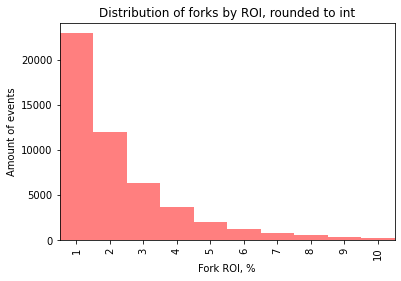

In [51]:
%matplotlib inline
fig2 = plt.figure()
data[data.fork == 1].PROFIT.round(0).map(int).value_counts().sort_index().plot.bar(color = 'r', alpha = 0.5, width = 1)

plt.xlim(0.5,10.5)
plt.ylabel('Amount of events')
plt.xlabel('Fork ROI, %')
plt.title('Distribution of forks by ROI, rounded to int')

In [49]:
######Scenario 1

# calculate amount of bets for qurtiles

cum_df = data[data.PROFIT > 0.01].PROFIT.sort_values().to_frame()
cum_df.reset_index(drop = True, inplace = True)
cum_df['PROFIT_CUM'] = cum_df['PROFIT'].cumsum().map(lambda x: round(x, 2))
cum_df['ROI'] = cum_df['PROFIT'].map(lambda x: round(x,2))
cum_df['PROCENTILE'] = cum_df['PROFIT_CUM'] / cum_df['PROFIT_CUM'].max() * 100

perc_dict = dict()
for perc in (25, 50 , 75, 100):
    temp_df = cum_df[cum_df.PROCENTILE >= perc]
    i = temp_df.head(1).index[0]
    max_roi = cum_df.loc[i,'ROI']
    bets = len(temp_df)
    profit = cum_df.loc[i,'PROFIT_CUM']
    print('ROI: {}, bets: {}. Profit: {}'.format(max_roi, bets, profit))
    perc_dict[perc] = (max_roi, profit)
    #print(max_roi)
    #print(i, max_roi)
#cum_df

cum_df.head(3)

ROI: 2.51, bets: 17507. Profit: 49716.77
ROI: 6.46, bets: 4491. Profit: 99432.21
ROI: 35.38, bets: 618. Profit: 149174.86
ROI: 1458.58, bets: 1. Profit: 198858.41


,PROFIT,PROFIT_CUM,ROI,PROCENTILE
0,0.010005,0.01,0.01,0.000005
1,0.010005,0.02,0.01,0.000010
2,0.010005,0.03,0.01,0.000015


C:\Users\vince\AppData\Local\Temp/ipykernel_13012/873948237.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels([str(10**x)+'%' for x in ax4.get_xticks()])
C:\Users\vince\AppData\Local\Temp/ipykernel_13012/873948237.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels([x // 1000 for x in ax4.get_yticks()])


Text(0.5, 1.0, 'Cumulative Profit vs ROI on logarithm scale')

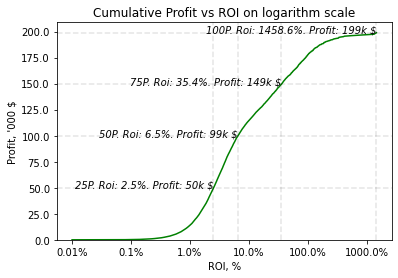

: 

In [52]:
# SCENARIO 2 
#fig4, ax = plt.subplots(111)
#plt.gca()
#fig4 = plt.figure()
#.loc[[2.51, 6.46, 35.38, 1458.58]]

import math
#math.log(100, 10)
fig4, ax4 = plt.subplots()
plot_df = cum_df.copy()

plot_df['ROI'] = plot_df.ROI.map(lambda x: math.log(x, 10))
plot_df = plot_df.drop_duplicates('ROI', keep = 'last').set_index('ROI')
plot_df.index.name = 'ROI, %'
#fig4 = plt.figure()
plot_df.PROFIT_CUM.plot(ax = ax4, color = 'green', alpha = 1)

ax4.set_xticklabels([str(10**x)+'%' for x in ax4.get_xticks()])
ax4.set_ylabel("Profit, '000 $")
ax4.set_ylim(0,)
ax4.set_yticklabels([x // 1000 for x in ax4.get_yticks()])

for p, (roi, pr) in perc_dict.items():
    log_x = math.log(roi, 10)
    plt.axvline(x= log_x, color = 'black', alpha = 0.1, ls = '--')
    plt.axhline(y= pr, color = 'black', alpha = 0.1, ls = '--')
#plt.axvline(x=math.log(6.46,10), color = 'black', alpha = 0.3)

    plt.text(log_x, pr, '{}P. Roi: {:.1f}%. Profit: {:.0f}k $'.format(p, roi, pr/1000), fontsize=10,horizontalalignment='right', fontstyle = 'italic')

#ax4.set_ylim(1000,200000)
#ROI: 2.51, bets: 17507. Profit: 49716.77
#№ROI: 6.46, bets: 4491. Profit: 99432.21
#№ROI: 35.38, bets: 618. Profit: 149174.86
#ROI: 1458.58, bets: 1. Profit: 198858.41
            
plt.title('Cumulative Profit vs ROI on logarithm scale')    

#cum_df.ROI.map
    
#cum_df.loc[[2.51, 6.46, 35.38, 1458.58]]
#cum_df